## NLP exploration on plot summaries

In [1]:
# Import the needed libarairies
import time # to monitor how long the NLP runs lasts

import pickle # in order to open the lexicon of american words
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter # to count tokens in each plot summaries
from geopy.geocoders import Nominatim # to only keep the GPE with the highest probabability, i.e London UK and not London Ohio, US
from concurrent.futures import ThreadPoolExecutor # to parallelize the use of the geopy
from tqdm import tqdm # to print a progress bar to know where the processing is

import torch # for fatser NLP processing
import spacy # for NLP analysis

# from itertools import zip_longest # to iterate over many lists at the same time

### CUDA verification in order to use laptop GPU. 
The used laptop for this analysis has the following graphic card: **Nvidia GeForce RTX 3050 Ti Laptop GPU**

In [2]:
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch CUDA available: True
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
nlp = spacy.load("en_core_web_trf")
print(nlp.pipeline)

c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_

[('transformer', <spacy_curated_transformers.pipeline.transformer.CuratedTransformer object at 0x000001BC96F59430>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x000001BC97282090>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x000001BC97067920>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x000001BC971CF350>), ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x000001BC971A5050>), ('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x000001BC97067840>)]


### Opening the cleaned dataframes created for P2 and P3

In [4]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
personas_mtd = pd.read_table('data/personas_metadata_CMU.csv', sep=',')

plot_summaries_df = pd.read_csv('data/plot_summaries_CMU.csv', sep = ',', usecols= ['ID', 'Summary'])

In [33]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

### Subdataset creation to faciliates the analysis

In [5]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

In [6]:
us_movies.head()

,wiki_movie_ID,freebase_movie_ID,title,release_date,box_office,runtime,languages,countries,genres_CMU,release_year,genres_IMDB,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,"Action,Horror,Sci-Fi",4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenet Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,NaN,NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"Silent film, English Language",United States of America,"Short Film, Silent film, Indie, Black-and-whit...",1913.0,"Comedy,Short",7.2,19.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0,"Drama,Music,Musical",6.8,2357.0
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,English Language,United States of America,"Drama, Black-and-white",1930.0,"Drama,Romance",5.4,356.0


### Opening of the Plot summaries dataset

In [7]:
# Increase the display width to see more characters per column
pd.set_option('display.max_colwidth', None)  # This removes the column width limit

# Display the first 3 lines (about 50 words) of each summary in the 'Summary' column
plot_summaries_df['Preview'] = plot_summaries_df['Summary'].apply(lambda x: ' '.join(x.split()[:50])) # x.split() splits the text into individual words, .join rebuilds the string after
# splitlines() to split into separate lines if the text already contains line breaks

# Show the first few rows with the Preview column
plot_summaries_df[['ID', 'Preview']].head()

# sort the plot summaries according to the Wikipedia movie ID
plot_summaries_df_sorted = plot_summaries_df.sort_values(ascending = True , by= 'ID')
plot_summaries_df_sorted[['ID', 'Preview']].head()

print(f"The size of the plot summaries dataset is {plot_summaries_df.shape}.")

plot_summaries_df.head()

The size of the plot summaries dataset is (42303, 3).


ID  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Merging the plot summaries dataset with the movie_mtd dataset in order to distinguish between US-only, partially US and non US produced (= RoW) movies

In [8]:
# Performing inner joins to be sure each movie kept after the merge has a plot summaries and filtering to keep only useful columnbs for the rest of the analysis
# ID column is not useful anymore so one can remove it
plot_summaries_all_movies = pd.merge(plot_summaries_df, all_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_movies = pd.merge(plot_summaries_df, us_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_partially_movies = pd.merge(plot_summaries_df, us_partially_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_RoW_movies = pd.merge(plot_summaries_df, rest_world_non_US, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

print(f"The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is {plot_summaries_all_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is {plot_summaries_us_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is {plot_summaries_us_partially_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is {plot_summaries_RoW_movies.shape}.")

plot_summaries_us_movies.head()

The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is (42208, 7).
The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is (17776, 7).
The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is (3015, 7).
The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is (18105, 7).


title  \
0    The Hunger Games   
1  The Lemon Drop Kid   
2          Dark Water   
3                Sing   
4       Meet John Doe   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Basics stats on the plot summaries

In [ ]:
# # Calculate the mean number of words per summary
# mean_number_words_per_summary = plot_summaries_df['word_count'].mean()

# # Count the number of words in each summary using len(x.split()) directly
# plot_summaries_df['word_count'] = plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) # count words in a string by splitting on spaces 8by default)

# number_summaries_more_500_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 500]['Summary'].count()
# number_summaries_more_1000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 1000]['Summary'].count()
# number_summaries_more_3000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) > 3000]['Summary'].count()


# print(f"Mean number of words per summary: {mean_number_words_per_summary:.2f}")

# print(f"The number of plot summaries with more than 500 words is {number_summaries_more_500_words}.")
# print(f"The number of plot summaries with more than 1000 words is {number_summaries_more_1000_words}.")
# print(f"The number of plot summaries with more than 3000 words is {number_summaries_more_3000_words}.")

# Whole dataset
basic_stats_numwords_plotsSummaries_all_movies = plot_summaries_all_movies['Summary'].apply(lambda x: len(str(x).split()))
# American movies STRICTLY produced in the US
#basic_stats_numwords_plotsSummaries_US = us_movies['Summary'].describe()
# American movies PARTIALLY produced in the US
# basic_stats_numwords_plotsSummaries_US_partial = us_partially_movies['box_office'].describe()
# # Rest of world (= Non Us movies)
# basic_stats_numwords_plotsSummaries_ROW = rest_world_non_US['box_office'].describe()

# dict_results = {'All movies': [basic_stats_box_office_all_movies.loc['50%'], basic_stats_box_office_all_movies.loc['mean'], basic_stats_box_office_all_movies.loc['std'], basic_stats_box_office_all_movies.loc['max'], basic_stats_box_office_all_movies.loc['min']], 
#                 'US-only produced': [basic_stats_box_office_US.loc['50%'], basic_stats_box_office_US.loc['mean'], basic_stats_box_office_US.loc['std'], basic_stats_box_office_US.loc['max'], basic_stats_box_office_US.loc['min']], 
#                 'Partially US-produced': [basic_stats_box_office_US_partial.loc['50%'], basic_stats_box_office_US_partial.loc['mean'], basic_stats_box_office_US_partial.loc['std'], basic_stats_box_office_US_partial.loc['max'], basic_stats_box_office_all_movies.loc['min']],
#                 'Non US produced (ROW)': [basic_stats_box_office_ROW.loc['50%'], basic_stats_box_office_ROW.loc['mean'], basic_stats_box_office_ROW.loc['std'], basic_stats_box_office_ROW.loc['max'], basic_stats_box_office_ROW.loc['min']]}

# df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
# # To display only 2 decimals after the comma taking advantage of the Jupyter notebook environment
# df_basic_stat_box_office.style.format("{:.2f}") 
# Apply the `nlp` function to each summary
plot_summaries_all_movies['Processed_Summary'] = plot_summaries_all_movies['Summary'].apply(lambda x: nlp(x))

# Extract tokens from the processed summaries (if needed)
plot_summaries_all_movies['Tokens'] = plot_summaries_all_movies['Processed_Summary'].apply(lambda doc: [token.text for token in doc])

# Example: Access the tokens from a single summary
print(plot_summaries_all_movies['Tokens'].iloc[0])
plot_summaries_all_movies.head()

from collections import Counter
# # with stopwords and ponctuation
# words = [token.text for token in doc]
word_freq = Counter(plot_summaries_all_movies['Tokens'])
common_words = word_freq.most_common() # five most common tokens
# # without stopwords and ponctuation
# words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
# word_freq = Counter(words)
# common_words = word_freq.most_common()

In [9]:
def plot_counter(df, lower_bound=1, upper_bound=20): # setting default lower and upper bounds value
    """
    Function that counts the number of plot summaries containing a given number of words.

    Params:
        df (pd.DataFrame): DataFrame containing a column 'Summary'.
        lower_bound (int, optional): Minimum number of words in a plot summary (exclusive).
                                     Use None to apply no lower bound. Default is 1.
        upper_bound (int, optional): Maximum number of words in a plot summary (inclusive).
                                     Default is 20.
    Returns: The count of summaries within the specified word count range (int).
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")

    # Compute plots counts once for efficiency
    plots_counts = df['Summary'].apply(lambda x: len(str(x).split())) # split words based on white spaces

    if lower_bound is None:
        # Apply only the upper bound
        return plots_counts[plots_counts >= upper_bound].count()
    else:
        # Apply both lower and upper bounds
        return plots_counts[(plots_counts > lower_bound) & (plots_counts <= upper_bound)].count()

# Initializing the need lists and dictionnary
list_name_df = ['All movies', 'US-only produced movies', 'Partially US-produced movies', 'Non US-produced movies']
list_df_plot_summaries = [plot_summaries_all_movies, plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies]
list_set_number_words = [[1, 20], [20, 100], [100, 300], [300,500], [500, 1000], [1000, 2000], [2000, 3000]] # ranges of numbers of words in order to count the number of plots summaries falling in that range
dict_plot_count = {'All movies': [], 'US-only produced movies': [], 
                   'Partially US-produced movies': [], 'Non US-produced movies': [], 
                   }

# Use of "zip" will make the loop terminates when the shortest iterable is exhausted so one put it in the second for loop to make sure all the 7 words count interval are processed
dict_plot_count = {name: [] for name in list_name_df}
interval_names = [f"{low}-{high}" for low, high in list_set_number_words]

for interval in list_set_number_words:
    for df, dico_name in zip(list_df_plot_summaries, list_name_df):
        word_count = plot_counter(df, lower_bound = interval[0], upper_bound = interval[1])
        dict_plot_count[dico_name].append(word_count)

# Create DataFrame with interval names as index and title
df_count_plot_summaries = pd.DataFrame(dict_plot_count, index=interval_names)

# Add a title for the rows as an index
df_count_plot_summaries.index.name = "Word number Interval"

# Compute the total number of plot summaries for each columns and add it as the last row of the df
df_count_plot_summaries.loc["Total"] = df_count_plot_summaries.sum(axis=0)

print("The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)")
df_count_plot_summaries.head(8)


The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)


,All movies,US-only produced movies,Partially US-produced movies,Non US-produced movies
Word number Interval,,,,
1-20,397,133,11,180
20-100,12137,4639,531,5662
100-300,14406,5600,702,6905
300-500,5933,2745,450,2392
500-1000,7867,3973,1073,2501
1000-2000,1381,658,235,428
2000-3000,69,25,10,29
Total,42190,17773,3012,18097


One notices first that most of the plot summaries show a number of words between 100 and 300. Next, come the plots having 20-100 words intheir summaries. One sees that they are very few plots summaries with more than 2000 words. Finally, one sees that with those word intervals one captures nearly all the movies. Indeed, th column *total* for all the movies shows 42190 movies out of 42208 (see above cell) meaning that only 18 plots summarie shave more than 3000 words. One observe similar behavior for the US-only produced, Partially US-produced and Non Us-produced movies.

Visualization

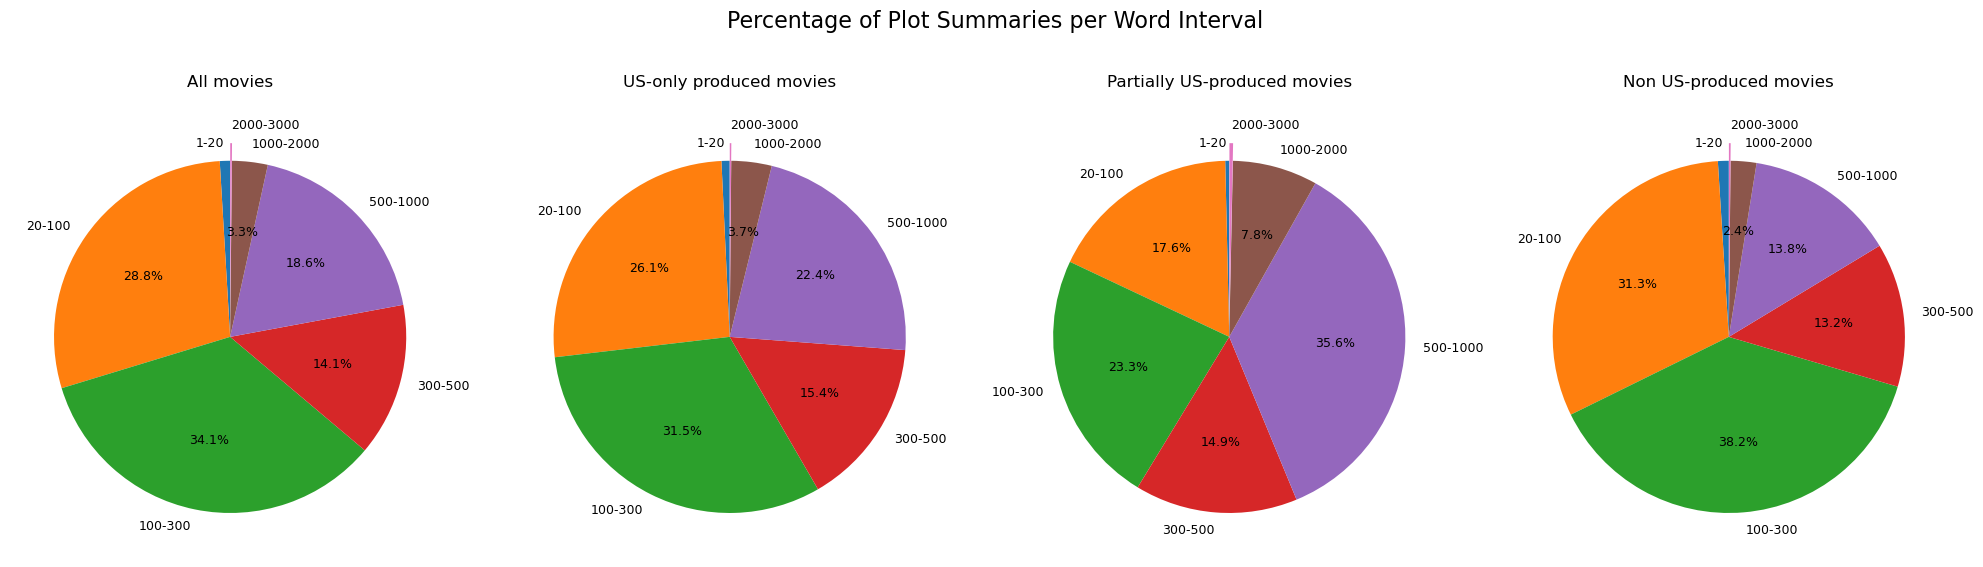

In [10]:
colors = sns.color_palette("pastel", len(df_count_plot_summaries.index))

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # Only display if percentage > 1%

plots = df_count_plot_summaries.iloc[:-1].plot.pie(
    subplots=True,
    figsize=(20, 8),
    title= False,
    legend=False,
    autopct=autopct_threshold,
    explode=(0, 0, 0, 0, 0, 0, 0.1),
    shadow=False,
    startangle=90,
    textprops={'fontsize': 9},
    color = colors
)

# Manually set the titles above the charts
titles = df_count_plot_summaries.columns
for ax, title in zip(plots, titles):
    ax.set_title(title, fontsize=12, y=1.05)  # Adjust y to move title above
    ax.set_ylabel('')  # Remove the default title on the left

# Global adjustments
plt.suptitle("Percentage of Plot Summaries per Word Interval", fontsize=16)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

# NLP on plot summaries

N.B: **For all the analysis below**, one processes **only the 3 following dataset: plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies** due to the very lomg running time. The complete plot summaries dataset from the CMU Corpus is not processed. It is not a problem for the purpose of the analysis since one seeks to study the movies depending on if they were produced in the US, partially in the US or completely abroad.

## Assessing the american culture in plots summaries using GPE (location only)
One recalls that GPE stands for *Geopolitical entity, i.e. countries, cities, states* ([see here](https://spacy.io/usage/linguistic-features/)). The aim is here to assess the "percentage" of amercian culture in each plot summaries by only looking at the locations present in the plot. Indeed, if the plot summary, i.e. the summary of the story told by the movie contains some amercian cities or states name it "represents" in a way the amercian culture since the movie director chose the US as a location to tell his story (or part of his story in other locations are present).

Retrieve all the **cities, counties and states in the US** in order **to create a set of the US locations**. This will serve to evaluate the "percentage" of amercian culture in each plot summaries by looking at the location of where the story of the movie is happening.

In [11]:
# List of all us states, counties and cities found on: https://github.com/grammakov/USA-cities-and-states/tree/master
df_us_states_counties_cities = pd.read_csv("data/us_cities_states_counties.csv", sep = "|")
print(f"The shape of the US states, counties and cities dataset is {df_us_states_counties_cities.shape}.")

# Exclude non-offcial US states that are comprised in the .csv from the Github page
exclude_states = [
    "US Armed Forces Pacific", "American Samoa", "Guam", "Palau",
    "Federated States of Micronesia", "Northern Mariana Islands",
    "Marshall Islands", "US Armed Forces Europe", "Puerto Rico", "Virgin Islands"
]

indices_to_drop = df_us_states_counties_cities[
    df_us_states_counties_cities['State full'].isin(exclude_states)
].index


df_us_states_counties_cities.drop(index=indices_to_drop, inplace=True)
print(f"The shape after dropping of the US states, counties and cities dataset is {df_us_states_counties_cities.shape}.")

# Create lists of unique city, county ans states names
list_US_states = list(df_us_states_counties_cities['State full'].unique())
list_US_counties = list(df_us_states_counties_cities['County'].str.capitalize().unique())
list_US_cities = list(df_us_states_counties_cities['City'].unique())

# Print the shapes and display only the first 10 locations of each list to avoid too long print statements
print(f"The list of the first ten US states is \n {list_US_states[:10]} \n and contains {len(list_US_states)} states.")
print(f"The list of the first ten US counties is \n {list_US_counties[:10]} \n and contains {len(list_US_counties)} counties.")
print(f"The list of the first ten US cities is \n {list_US_cities[:10]} \n and contains {len(list_US_cities)} cities.")

# Combine all US states, counties, and cities into a single set for faster lookup
us_locations_set = set(list_US_states + list_US_counties + list_US_cities)

df_us_states_counties_cities.head()

The shape of the US states, counties and cities dataset is (63210, 5).
The shape after dropping of the US states, counties and cities dataset is (60451, 5).
The list of the first ten US states is 
 ['New York', 'Massachusetts', 'Rhode Island', 'New Hampshire', 'Maine', 'Vermont', 'Connecticut', 'New Jersey', 'Pennsylvania', 'Delaware'] 
 and contains 51 states.
The list of the first ten US counties is 
 ['Suffolk', 'Hampden', 'Hampshire', 'Worcester', 'Berkshire', 'Franklin', 'Middlesex', 'Essex', 'Plymouth', 'Norfolk'] 
 and contains 1847 counties.
The list of the first ten US cities is 
 ['Holtsville', 'Agawam', 'Amherst', 'Barre', 'Belchertown', 'Blandford', 'Bondsville', 'Brimfield', 'Chester', 'Chesterfield'] 
 and contains 18736 cities.


,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2696,Agawam,MA,Massachusetts,HAMPDEN,Agawam
2697,Amherst,MA,Massachusetts,HAMPSHIRE,Amherst
2698,Amherst,MA,Massachusetts,HAMPSHIRE,Cushman


In [ ]:
# nlp = spacy.load('en_core_web_sm')

# # Creating deep copy of the plots_summaries dataframes creatde above 
# df_plots_all_movies_GPE = plot_summaries_all_movies.copy()
# df_plots_us_movies_GPE = plot_summaries_us_movies.copy()
# df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy() # run en 5'30"
# df_plots_RoW_GPE = plot_summaries_RoW_movies.copy()

# # since GPE is part of the NER spacy pipeline, no need to tokenize manually the text before implementing the search for GPE quantities
# # def extract_gpe(summary):
# #     """ Function that extract the GPE entities of a plot summary
# #     params: a text called 'summary'
# #     returns: all the GPE entities detected in the summary
# #     """
# #     doc = nlp(summary)
# #     return [ent.text for ent in doc.ents if ent.label_ == 'GPE'] # outputs all detected geopolitical entities, including repeated mentions of the same geographical entitities

# # def compute_US_GPE_frequencies(summary, set_us_location):
# #     """ Function that extract the US GPE frequencies of a plot summary
# #     params: a text called 'summary' and a set of US locations containing the cities, counties and the states
# #     returns: all the US GPE frequencies detected in the summary
# #     """

# def extract_GPE_and_compute_US_frequencies(summary, set_us_location):
#     """ Function that extract the GPE entities of a plot summary
#     params: a text called 'summary' and a set of US locations containing the cities, counties and the states
#     returns: all the GPE entities and all the US GPE frequencies detected in the summary
#     """
#     doc = nlp(summary)
#     GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
#     GPE_frequencies_all = Counter(GPE_entities)
#     GPE_US_frequencies = Counter(entity for entity in GPE_entities if entity in set_us_location)
#     Percentage_US_culture = sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values()) if sum(GPE_frequencies_all.values()) > 0 else 0
#     return GPE_entities, GPE_US_frequencies, Percentage_US_culture

# # Unpacking the results of the function
# df_plots_us_partially_movies_GPE['GPE_entities'], df_plots_us_partially_movies_GPE['GPE_US_frequencies'], df_plots_us_partially_movies_GPE['Percentage_american_culture'] = df_plots_us_partially_movies_GPE['Summary'].apply(extract_GPE_and_compute_US_frequencies)


# # df_plots_us_partially_movies_GPE['GPE_frequencies'] = df_plots_us_partially_movies_GPE['GPE_entities'].apply(
# #     lambda entities: Counter(entities) # use of library Counzter for efficient processing
# # ) # ENLEVER POUR LA SUITE



# # Filter GPE entities to retain only those matching US locations
# # df_plots_us_partially_movies_GPE['GPE_US_frequencies'] = df_plots_us_partially_movies_GPE['GPE_entities'].apply(
# #     lambda entities: Counter(entity for entity in entities if entity in us_locations_set)
# # )

# # "Percentage" of american culture
# # df_plots_us_partially_movies_GPE['Percentage_american_culture'] = df_plots_us_partially_movies_GPE.apply(
# #     lambda row: sum(row['GPE_US_frequencies'].values()) / sum(row['GPE_frequencies'].values())
# #     if sum(row['GPE_frequencies'].values()) > 0 else 0,
# #     axis=1
# # )

# df_plots_us_partially_movies_GPE.head()


,ID,Summary,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_frequencies,GPE_US_frequencies,Percentage_american_culture
0,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy returns to the tent to check on Azaria and is certain she sees a dingo with something in its mouth running off as she approaches. When she discovers the infant is missing, everyone joins forces to search for her, without success. It is assumed what Lindy saw was the animal carrying off the child, and a subsequent inquest rules her account of events is true. The tide of public opinion soon turns against the Chamberlains. For many, Lindy seems too stoic, too cold-hearted, and too accepting of the disaster that has befallen her. Gossip about her begins to swell and soon is accepted as statements of fact. The couple's beliefs are not widely practised in the country, and when the media report a rumour that the name Azaria means ""sacrifice in the wilderness"" , the public is quick to believe they decapitated their baby with a pair of scissors as part of a bizarre religious rite. Law-enforcement officials find new witnesses, forensics experts, and a lot of circumstantial evidence—including a small wooden coffin Michael uses as a receptacle for his parishioners' packs of un-smoked cigarettes—and reopen the investigation, and eventually Lindy is charged with murder. Seven months pregnant, she ignores her attorneys' advice to play on the jury's sympathy and appears emotionless on the stand, convincing onlookers she is guilty of the crime of which she is accused. As the trial progresses, Michael's faith in his religion and his belief in his wife disintegrate, and he stumbles through his testimony, suggesting he is concealing the truth. In October 1982, Lindy is found guilty and sentenced to life imprisonment with hard labour, while Michael is found guilty as an accessory and given an 18-month suspended sentence. More than three years later, while searching for the body of an English tourist who fell from Uluru, police discover a small item of clothing that is identified as the jacket Lindy had insisted Azaria was wearing over her jumpsuit, which had been recovered early in the investigation. She is immediately released from prison, the case reopened and all convictions against the Chamberlains overturned.",A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,"[Azaria, Lindy, Lindy, Uluru]","{'Azaria': 1, 'Lindy': 2, 'Uluru': 1}",{},0.000000
1,5272176,"The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by the bullet that hits the president. The shooter is gunned down by Alex and other secret service agents. The president dies at the hospital. Kate Crawford , an investigative journalist, starts asking questions about the assassination. Anyone she questions is killed. She goes to Alex Thomas's house to tell him what is happening. As they head to his boat, Thomas sees some men hiding in the bushes. He throws Kate into the water and dives in. Thomas jumps out of the water to kill two of the hitmen while a third hitman drives off to inform his boss what happened. They are able to link the hitmen to a man called Jack Baldwin . Agent Thomas and other Secret Service members attack the location of Jack Baldwin. Baldwin escapes but is later caught by Thomas. Thomas and Crawford are suspicious of Vaughan Stevens , Agent Thomas's boss, who had previous links to Baldwin. While reviewing film of the assassination at his house, Thomas discovers that Stevens handed the assa

In [ ]:
# mean_amercian_culture_us_partially_movies_GPE = df_plots_us_partially_movies_GPE['Percentage_american_culture'].mean()

# print(f"The mean percenatge of amercian culture of partially US-produced movies based on location only is {mean_amercian_culture_us_partially_movies_GPE*100:.2f} %.")

The mean percenatge of amercian culture of partially US-produced movies based on location only is 36.57 %.


# TEST AVEC NOMINATIM Sur les plots problématiques

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu()  # Enable GPU use for SpaCy
    nlp = spacy.load("en_core_web_trf")  # Use a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# Geocode a single location and check if it's in the US
def geocode_location(location):
    geolocator = Nominatim(user_agent="location_disambiguator", timeout=10)
    locate = geolocator.geocode(location)
    check = True if locate and 'United States' in str(locate) else False
    return location, check

# Geocode multiple locations in parallel
def geocode_locations_parallel(locations):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(geocode_location, locations), total=len(locations), desc="Geocoding Locations"))
    return results

# Extract GPE entities and compute US frequencies with geocoding
def extract_GPE_and_compute_US_frequencies_batch(summaries):
    results = []
    for doc in tqdm(nlp.pipe(summaries, batch_size=500), total=len(summaries), desc="Processing Summaries"):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        geocoded_results = geocode_locations_parallel(GPE_entities)
        GPE_US_frequencies = Counter(location for location, is_in_us in geocoded_results if is_in_us)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Example DataFrame setup and processing
# Assuming df_plots_us_partially_movies_GPE is already defined
df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy()

start_time = time.time()
print("Processing starting.")


# Apply batch processing with GPU
df_plots_us_partially_movies_GPE[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = pd.DataFrame(
    extract_GPE_and_compute_US_frequencies_batch(
        df_plots_us_partially_movies_GPE['Summary'].tolist()
    ))

# Drop summaries and save results
df_us_partially_movies_NLP_GPE = df_plots_us_partially_movies_GPE.drop(columns=['Summary'])
df_us_partially_movies_NLP_GPE.to_csv("data/NLP_datasets/us_partially_movies_NLP_GPE_test_problems.csv", sep=',', encoding='utf-8', index=False, header=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")


Test on five plots

In [24]:

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu()  # Enable GPU use for SpaCy
    nlp = spacy.load("en_core_web_trf")  # Use a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# Geocode a single location and check if it's in the US
def geocode_location(location):
    geolocator = Nominatim(user_agent="location_disambiguator", timeout=10)
    locate = geolocator.geocode(location)
    check = True if locate and 'United States' in str(locate) else False
    return location, check

# Geocode multiple locations in parallel
def geocode_locations_parallel(locations):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(geocode_location, locations))
    return results

# Extract GPE entities and compute US frequencies with geocoding
def extract_GPE_and_compute_US_frequencies_batch(summaries):
    results = []
    for doc in tqdm(nlp.pipe(summaries, batch_size=500), total=len(summaries), desc="Processing Summaries"):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        geocoded_results = geocode_locations_parallel(GPE_entities)
        GPE_US_frequencies = Counter(location for location, is_in_us in geocoded_results if is_in_us)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Example DataFrame setup and processing
# Assuming df_plots_us_partially_movies_GPE is already defined
# df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy()

start_time = time.time()
print("Processing starting.")


# Filter DataFrame for selected movie titles
selected_titles = ["Eastern Promises",  "Sophie's Choice"] # "Come Back, Africa", "A Cry in the Dark", "End Game",
filtered_df = plot_summaries_us_partially_movies[plot_summaries_us_partially_movies['title'].isin(selected_titles)].copy()

# Apply batch processing with GPU
filtered_df[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = pd.DataFrame(
    extract_GPE_and_compute_US_frequencies_batch(
        filtered_df['Summary'].tolist()
    ))

# Drop summaries and save results
filtered_df = filtered_df.drop(columns=['Summary']) ########### prOBLEM ICI
filtered_df.to_csv("data/NLP_datasets/us_partially_movies_NLP_GPE_test_problems.csv", sep=',', encoding='utf-8', index=False, header=True)


end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

filtered_df.head()

CUDA is available. Using GPU.


c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_

Processing starting.


Processing Summaries:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
Processing Summaries: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

Execution time: 0.09 minutes. NLP processing done.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
6,Eastern Promises,17266000.0,NaN,2007.0,NaN,NaN,NaN,NaN,NaN
8,Sophie's Choice,30036000.0,"Drama,Romance",1982.0,7.5,53987.0,NaN,NaN,NaN


In [20]:
# Check the structure of the output
output = extract_GPE_and_compute_US_frequencies_batch(filtered_df['Summary'].tolist())

# Check the length of output and the filtered DataFrame
print(len(output), len(filtered_df))

# Check the structure of the first few entries of the output
print(output[:5])

# If the output is correct, try assigning it again
filtered_df[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = pd.DataFrame(output, columns=['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture'])

# Check the DataFrame after assignment
print(filtered_df.head())


Processing Summaries:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
Processing Summaries: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]

2 2
[(['London', 'UK', 'London', 'Edinburgh'], Counter(), 0.0), (['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia'], Counter({'Brooklyn': 2, 'Virginia': 1}), 0.75)]
              title  \
6  Eastern Promises   
8   Sophie's Choice   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [22]:
print(f"Output length: {len(output)}")
print(f"Filtered DataFrame length: {len(filtered_df)}")
print(f"Output structure (first 2 entries): {output[:2]}")

# Convert output to DataFrame first
temp_df = pd.DataFrame(output, columns=['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture'])

# Check if the DataFrame is correct
print(temp_df.head())

# Assign it back to filtered_df
filtered_df[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = temp_df
print(filtered_df.head())


Output length: 2
Filtered DataFrame length: 2
Output structure (first 2 entries): [(['London', 'UK', 'London', 'Edinburgh'], Counter(), 0.0), (['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia'], Counter({'Brooklyn': 2, 'Virginia': 1}), 0.75)]
                           GPE_entities              GPE_US_frequencies  \
0       [London, UK, London, Edinburgh]                              {}   
1  [Brooklyn, U.S., Brooklyn, Virginia]  {'Brooklyn': 2, 'Virginia': 1}   

   Percentage_american_culture  
0                         0.00  
1                         0.75  
              title  \
6  Eastern Promises   
8   Sophie's Choice   

                                                                                                                                                                                                                                                                                                                                                                                

In [19]:
selected_titles = ["Eastern Promises",  "Sophie's Choice"] # "Come Back, Africa", "A Cry in the Dark", "End Game",
filtered_df = plot_summaries_us_partially_movies[plot_summaries_us_partially_movies['title'].isin(selected_titles)].copy()

for doc in nlp.pipe([filtered_df.loc[filtered_df['title'] == "Eastern Promises", 'Summary'].iloc[0]]):
    print([ent.text for ent in doc.ents if ent.label_ == 'GPE'])
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    geocoded_results = geocode_locations_parallel(locations)
    print(geocoded_results)

output = extract_GPE_and_compute_US_frequencies_batch(
    filtered_df['Summary'].tolist()
)
print(output)
print(len(output), len(filtered_df))


filtered_df

c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


['London', 'UK', 'London', 'Edinburgh']
[('London', False), ('UK', False), ('London', False), ('Edinburgh', False)]


Processing Summaries: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]

[(['London', 'UK', 'London', 'Edinburgh'], Counter(), 0.0), (['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia'], Counter({'Brooklyn': 2, 'Virginia': 1}), 0.75)]
2 2


,title,Summary,box_office,genres_IMDB,release_year,averageRating,numVotes
6,Eastern Promises,"Anna Khitrova , a British-Russian midwife at a London hospital, finds a Russian-language diary on the body of Tatiana, a 14-year-old girl who dies in childbirth. She also finds a card for the Trans-Siberian restaurant, which is owned by Semyon , an old vor in the Russian Mafia. Anna thus sets out to track down the girl's family so that she can find a home for the baby girl, having meetings with Semyon who she initially regards as friendly. Anna's mother Helen does not discourage her, but Anna's Ukrainian uncle and self-described former KGB officer, Stepan , whom Anna asks for help with the translation of the diary, urges caution. Through translation of the diary, Anna comes to learn that Semyon and his unstable son Kirill , had abused the girl, addicted her to heroin, forced her into prostitution and raped her. Ultimately Anna realises that the baby was fathered by Semyon. Semyon's driver is Nikolai Luzhin , who also serves as the family cleaner, dumping murdered bodies in the River Thames. Through Nikolai, Semyon, fearing prosecution, promises to give the location of the girl's family to Anna if she hands back the diary. Nikolai takes the diary but does not give a location, instead later urging Anna to keep the baby in the UK as the girl's home is a bad village to grow up in. Semyon distrusts Anna's uncle Stepan due to his former position and ethnicity, ordering a hit on him. Nikolai accepts and soon Stepan goes missing. As Nikolai's star rises within the vory, an impressed Semyon sponsors him as a full member, with the appropriate tattoos, due in part to Nikolai's protection of Semyon's incompetent son who authorized a hit on a rival Chechen vory leader with the help of a kurdish associate, Azim. The hit was not approved by Semyon and was ill-advised; the Chechen gang are now coming to London to seek vengeance having killed Azim's nephew. Semyon hatches a plan to trick Nikolai into temporarily taking Kirill's place during a meeting at the baths with Azim. The Chechens attack, thinking Nikolai is Kirill, but Nikolai kills them both and ends up in hospital with severe wounds as a result. It is then revealed that Nikolai is actually an FSB agent who has infiltrated the gang, working under license by the British Government and a Senior Officer . As part of his undercover duties, Nikolai was able to read Tatiana's diary before Semyon had it destroyed and hatched a plan to have Semyon arrested for statutory rape, with a paternity test of the Tatiana's baby as evidence. Stepan is also safe, hiding in a 5-star hotel in Edinburgh for protection. Semyon orders Kirill to kidnap the baby girl and kill her but as Kirill sits by the Thames, almost unable to throw the little girl into the river, Nikolai and Anna find him and persuade him to give the baby back. Nikolai and Kirill embrace as Nikolai tells him that his father is finished and they are now the bosses. Nikolai and Anna then kiss as they part for the last time. Nikolai succeeds Semyon's place as boss of the organization and Anna gains custody of Tatiana's baby, whom she raises as Christine.",17266000.0,NaN,2007.0,NaN,NaN
8,Sophie's Choice,"In 1947, the movie's narrator, Stingo , relocates to Brooklyn in order to write a novel and is befriended by Sophie Zawistowski , a Polish immigrant, and her lover, Nathan Landau . One evening, Stingo learns from Sophie that she was married but her husband and her father were killed in a German work camp and that she was interned in the Auschwitz concentration camp. Nathan is constantly jealous, and when he is in one of his violent mood swings he convinces himself that Sophie is unfaithful to him and abuses and harasses her. There is a flashback showing Nathan rescuing Sophie from near death from anemia shortly after her immigration to the U.S. Sophie eventually reveals that her father was a Nazi sympathizer. Sophie had a lover, Józef , who lived with 

#### 1) Processing the partially US-produced movies
Each of the 3 "sub"-dataframes are processed separately due to the consequent running time due to the use of the `en_core_web_trf` spacy NLP model (see below). Moreover one must keep in mind that this cell runs in about $\color{red}{40 minutes}$ with the **Nvidia GeForce RTX 3050 Ti Laptop GPU** used here.

In [ ]:
# Acknowledement: ChatGPT was used here in order to better understand how to work with CUDA and with the NLP pipeline (https://chatgpt.com/)

# Creating deep copy of the plots_summaries dataframes creatde above 
df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy()

# Verify if laptop running the script has a GPU and CUDA enabled
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu() # enable GPU use for Spacy, taken from: https://stackoverflow.com/questions/75355264/how-to-enable-cuda-gpu-acceleration-for-spacy-on-windows 
    nlp = spacy.load("en_core_web_trf") # uses a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# 
def extract_GPE_and_compute_US_frequencies_batch(summaries, us_locations):
    """
    Function that implement batch processing of plot summaries and extract GPE entities and frequencies. If available on the machine running the notebook, CUDA is enabled for faster processing.
    params: texts called 'summaries' and a set of US locations containing the cities, counties and the states
    returns: all the GPE entities and all the US GPE frequencies detected in the summary as a list
    """
    results = []
    for doc in nlp.pipe(summaries, batch_size=500):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        GPE_US_frequencies = Counter(ent for ent in GPE_entities if ent in us_locations)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Apply batch processing with GPU
df_plots_us_partially_movies_GPE[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = \
    pd.DataFrame(extract_GPE_and_compute_US_frequencies_batch(
        df_plots_us_partially_movies_GPE['Summary'].tolist(), us_locations_set # converts a Pandas Series into a Python list, as nlp.pipe expects a seqeunce of string according to the documentation https://spacy.io/api/language#pipe 
    ))

df_us_partially_movies_NLP_GPE = df_plots_us_partially_movies_GPE.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_us_partially_movies_NLP_GPE.to_csv("data/us_partially_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

print("NLP processing done.")

CUDA is available. Using GPU.


c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Quick visualization of the results

In [28]:
df_GPE_partially_us = pd.read_csv("data/us_partially_movies_NLP_GPE.csv", sep=',')

# count the proportions of zeros
df_GPE_partially_us['Percentage_american_culture'] = pd.to_numeric(df_GPE_partially_us['Percentage_american_culture']).astype('float64')
proportion_0_percenatge = (len(df_GPE_partially_us[df_GPE_partially_us['Percentage_american_culture'] == 0.0])/len(df_GPE_partially_us))*100

print(f"The percentage of zero values on the partially US GPE dataset is: {proportion_0_percenatge:.2f} %.")

df_GPE_partially_us.head(10)
# https://en.wikipedia.org/wiki/London,_Ohio
# https://en.wikipedia.org/wiki/Edinburgh,_Indiana 

The percentage of zero values on the partially US GPE dataset is: 47.76 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,"['Azaria', 'Uluru']",Counter(),0.00
1,End Game,NaN,"Action,Thriller",2006.0,5.1,5745.0,[],Counter(),0.00
2,"Come Back, Africa",NaN,NaN,1960.0,NaN,NaN,"['Johannesburg', 'Sophiatown']",Counter({'Johannesburg': 1}),0.50
3,Kehtaa Hai Dil Baar Baar,NaN,"Comedy,Drama,Romance",2002.0,4.7,204.0,"['India', 'New York']",Counter({'New York': 1}),0.50
4,Pieces,2032311.0,NaN,1982.0,NaN,NaN,['Boston'],Counter({'Boston': 1}),1.00
5,The Good Life,NaN,"Comedy,Drama",2007.0,6.4,2352.0,['Nebraska'],Counter({'Nebraska': 1}),1.00
6,Eastern Promises,17266000.0,NaN,2007.0,NaN,NaN,"['London', 'UK', 'London', 'Edinburgh']","Counter({'London': 2, 'Edinburgh': 1})",0.75
7,"Wait Until Spring, Bandini",NaN,Drama,1989.0,6.2,754.0,['Colorado'],Counter({'Colorado': 1}),1.00
8,Sophie's Choice,30036000.0,"Drama,Romance",1982.0,7.5,53987.0,"['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia']","Counter({'Brooklyn': 2, 'Virginia': 1})",0.75
9,Until Death,NaN,"Action,Crime,Drama",2007.0,5.7,10503.0,"['New Orleans', 'New Orleans']",Counter({'New Orleans': 2}),1.00


#### 2) Processing the US-only produced movies

In [12]:
df_plots_us_only_movies_GPE = plot_summaries_us_movies.copy()

start_time = time.time()
print("Processing starting.")

# Verify if laptop running the script has a GPU and CUDA enabled
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu() # enable GPU use for Spacy, taken from: https://stackoverflow.com/questions/75355264/how-to-enable-cuda-gpu-acceleration-for-spacy-on-windows 
    nlp = spacy.load("en_core_web_trf") # uses a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# 
def extract_GPE_and_compute_US_frequencies_batch(summaries, us_locations):
    """
    Function that implement batch processing of plot summaries and extract GPE entities and frequencies. If available on the machine running the notebook, CUDA is enabled for faster processing.
    params: texts called 'summaries' and a set of US locations containing the cities, counties and the states
    returns: all the GPE entities and all the US GPE frequencies detected in the summary as a list
    """
    results = []
    for doc in nlp.pipe(summaries, batch_size=200):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        GPE_US_frequencies = Counter(ent for ent in GPE_entities if ent in us_locations)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Apply batch processing with GPU
df_plots_us_only_movies_GPE[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = \
    pd.DataFrame(extract_GPE_and_compute_US_frequencies_batch(
        df_plots_us_only_movies_GPE['Summary'].tolist(), us_locations_set # converts a Pandas Series into a Python list, as nlp.pipe expects a seqeunce of string according to the documentation https://spacy.io/api/language#pipe 
    ))

df_us_only_movies_NLP_GPE = df_plots_us_only_movies_GPE.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_us_only_movies_NLP_GPE.to_csv("data/us_only_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

Processing starting.
CUDA is available. Using GPU.


c:\Users\luca\miniconda3\envs\ada\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_

Execution time: 143.19 minutes. NLP processing done.


Quick visualization of the results

In [24]:
# Visualization of the result:
df_GPE_us_only = pd.read_csv("data/us_only_movies_NLP_GPE.csv", sep=',')

# count the proportions of zeros
df_GPE_us_only['Percentage_american_culture'] = pd.to_numeric(df_GPE_us_only['Percentage_american_culture']).astype('float64')
proportion_0_percenatge = (len(df_GPE_us_only[df_GPE_us_only['Percentage_american_culture'] == 0.0])/len(df_GPE_us_only))*100

print(f"The percentage of zero values on the US onyl GEP dataset is: {proportion_0_percenatge:.2f} %.")

df_GPE_us_only.head(10)
# https://en.wikipedia.org/wiki/Palestine,_Texas

The percentage of zero values on the US onyl GEP dataset is: 56.10 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,The Hunger Games,686533290.0,"Action,Adventure,Sci-Fi",2012.0,7.2,1022897.0,['Panem'],Counter(),0.000000
1,The Lemon Drop Kid,2300000.0,"Comedy,Crime,Music",1951.0,7.0,2303.0,"['New York City', 'Florida', 'New York', 'New York', 'Manhattan', 'Nyack', 'Nellie']","Counter({'New York': 2, 'Florida': 1, 'Manhattan': 1, 'Nyack': 1})",0.714286
2,Dark Water,49483352.0,"Drama,Horror,Mystery",2005.0,5.6,66164.0,"['Jersey City', 'Roosevelt Island', 'Jersey City']",Counter({'Jersey City': 2}),0.666667
3,Sing,2260616.0,"Drama,Musical",1989.0,6.7,974.0,['Brooklyn'],Counter({'Brooklyn': 1}),1.000000
4,Meet John Doe,NaN,"Comedy,Drama,Romance",1941.0,7.6,15255.0,['Millsville'],Counter(),0.000000
5,Husband for Hire,NaN,NaN,2008.0,NaN,NaN,"['Texas', 'New Mexico']","Counter({'Texas': 1, 'New Mexico': 1})",1.000000
6,Exodus,NaN,NaN,1960.0,NaN,NaN,"['Israel', 'Cyprus', 'Palestine', 'Mandate Palestine', 'Famagusta', 'America', 'Palestine', 'Jerusalem', 'Abu Yesha', 'Gan Dafna', 'Israel', 'Jerusalem', 'Gan Dafna', 'Gan Dafna']","Counter({'Palestine': 2, 'Jerusalem': 2})",0.285714
7,House Party 2,19438638.0,"Comedy,Drama,Music",1991.0,5.3,7205.0,[],Counter(),0.000000
8,Charlie Chan's Secret,NaN,NaN,1936.0,NaN,NaN,[],Counter(),0.000000
9,The Biggest Fan,NaN,NaN,2002.0,NaN,NaN,[],Counter(),0.000000


#### 3) Processing the partially Non-US (RoW) produced movies

In [ ]:
df_plots_RoW_GPE = plot_summaries_RoW_movies.copy()

start_time = time.time()
print("Processing starting.")

# Verify if laptop running the script has a GPU and CUDA enabled
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu() # enable GPU use for Spacy, taken from: https://stackoverflow.com/questions/75355264/how-to-enable-cuda-gpu-acceleration-for-spacy-on-windows 
    nlp = spacy.load("en_core_web_trf") # uses a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# 
def extract_GPE_and_compute_US_frequencies_batch(summaries, us_locations):
    """
    Function that implement batch processing of plot summaries and extract GPE entities and frequencies. If available on the machine running the notebook, CUDA is enabled for faster processing.
    params: texts called 'summaries' and a set of US locations containing the cities, counties and the states
    returns: all the GPE entities and all the US GPE frequencies detected in the summary as a list
    """
    results = []
    for doc in nlp.pipe(summaries, batch_size=200):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        GPE_US_frequencies = Counter(ent for ent in GPE_entities if ent in us_locations)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Apply batch processing with GPU
df_plots_RoW_GPE[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = \
    pd.DataFrame(extract_GPE_and_compute_US_frequencies_batch(
        df_plots_RoW_GPE['Summary'].tolist(), us_locations_set # converts a Pandas Series into a Python list, as nlp.pipe expects a seqeunce of string according to the documentation https://spacy.io/api/language#pipe 
    ))

df_RoW_movies_NLP_GPE = df_plots_RoW_GPE.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_RoW_movies_NLP_GPE.to_csv("data/RoW_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

Quick visualization of the results

#### Opening all three dataset to calculate the mean percentage of american culture 

In [26]:
df_GPE_partially_us = pd.read_csv("data/us_partially_movies_NLP_GPE.csv", sep=',')
df_GPE_us_only = pd.read_csv("data/us_only_movies_NLP_GPE.csv", sep=',')
# df_GPE_RoW = pd.read_csv("data/Row_movies_NLP_GPE.csv", sep=',')

# list_df_names = ['US-only American movies', 'Partially US-produced movies' , 'Rest of world']
# list_df_GPE_results = [df_GPE_us_only, df_GPE_partially_us, df_GPE_RoW]
# mean_american_culture_GPE_results = []

# for name, df in zip(list_df_names, list_df_GPE_results):
#     mean_american_culture_GPE_results.append(df['Percentage_american_culture'].mean()*100)

mean_american_culture_GPE_partially_us_movies = df_GPE_partially_us['Percentage_american_culture'].mean()*100
mean_american_culture_GPE_us_only_movies = df_GPE_us_only['Percentage_american_culture'].mean()*100

print(f"The mean american culture percentage for Partially US produced movies using only GPE information is {mean_american_culture_GPE_partially_us_movies:.2f} %.")
print(f"The mean american culture percentage for US-only produced movies using only GPE information is {mean_american_culture_GPE_us_only_movies:.2f} %.")

The mean american culture percentage for Partially US produced movies using only GPE information is 37.59 %.
The mean american culture percentage for US-only produced movies using only GPE information is 36.11 %.


Visualization using a bar chart

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(list_name_df, mean_american_culture_GPE_results, edgecolor ='black')
plt.ylabel("Mean american culture using GPE [%]")
plt.title("Mean amercian culture percentage in plots summaries using GPE only for producing movie country")
plt.tight_layout()
#plt.savefig("data/plots_best/mean_american_culture_GPE.png", dpi = 300)

## Assessing the american culture in plots summaries using the crafted amercian words lexicon
The goal is here to scan once again the plot summaries of US-only, partially US- and Non-US produced movies but this time with a **handcrafted lexicon representing a realistic and robust sample of the american culture**. For more details about how this lexicon was created, please look at the notebook called *American_vocab.ipynb* (**pas oublier de modifer le nom au cas où on change le nom du notebook**).

Once again, each of the 3 "sub"-dataframes are processed separately due to the consequent running time due to the use of the `en_core_web_trf` spacy NLP model (see below).

Load the set of american words representing the lexicon created from Wikipedia data (see notebook *american_vocab.ipynb*) for more details

In [22]:
with open('data/unique_us_words_set.pkl', 'rb') as f:
    unique_us_words_set = pickle.load(f)

print(f"The lexicon of amercian words contains {len(unique_us_words_set)} words.")
print(f"The words of the lexicon are:\n {unique_us_words_set}")

The lexicon of amercian words contains 757 words.
The words of the lexicon are:
 {'san', 'genome', 'mayflower', 'moby', 'mariana', 'mars', 'reed', 'airplane', 'honors', 'movie', 'temper', 'heterogenous', 'homeless', 'eurodollar', 'transitional', 'riaa', 'squash', 'hate', 'reelect', 'dialogue', 'macaroni', 'humanitiesinstitute', 'centers', 'oversight', 'ion', 'favor', 'realist', 'jackson', 'ethic', 'mcclatchy', 'allay', 'aggression', 'shows', 'jelly', 'conversion', 'homeschool', 'lease', 'humanitiesthe', 'persistent', 'lee', 'sheltered', 'flowering', 'periodical', 'initialism', 'payload', 'shortening', 'gannett', 'englishmen', 'protestantism', 'intercollegiate', 'patent', 'hasten', 'confine', 'dunkin', 'surviving', 'congressional', 'yorktown', 'pew', 'aristocracy', 'alaskan', 'widow', 'beecher', 'prescribed', 'morton', 'usa', 'brief', 'removal', 'desecration', 'rhythmic', 'awakening', 'restorationist', 'dash', 'limitation', 'puerto', 'synonymous', 'noble', 'phoenix', 'kuwait', 'services

Creating the function that will process all the data along with the lexicon

#### 1) Processing the partially US-produced movies

In [ ]:
df_plots_us_partially_movies_lexicon = plot_summaries_us_partially_movies.copy()

# Monitor the running time of this cell
start_time = time.time()
print("Processing starting.")

# Verify if laptop running the script has a GPU and CUDA enabled
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu() # enable GPU use for Spacy, taken from: https://stackoverflow.com/questions/75355264/how-to-enable-cuda-gpu-acceleration-for-spacy-on-windows 
    nlp = spacy.load("en_core_web_trf") # uses a more complex model leveraging transformers
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")


def compute_US_lexicon_frequencies_batch(summaries, us_lexicon):
    """
    Function that implement batch processing of plot summaries and extract GPE entities and frequencies. If available on the machine running the notebook, CUDA is enabled for faster processing.
    params: texts called 'summaries' and a set of US locations containing the cities, counties and the states
    returns: all the token entities and all the US token frequencies detected in the summary as a list
    """
    results = []
    for doc in nlp.pipe(summaries, batch_size=500):
        summary_tokens = [token.text.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha] # lemmatize, lower all letters, remove stopwords and numbers
        Tokens_frequencies_all = Counter(summary_tokens)
        Tokens_US_frequencies = Counter(token for token in summary_tokens if token in us_lexicon)
        Percentage_US_culture_lexicon = (
            sum(Tokens_US_frequencies.values()) / sum(Tokens_frequencies_all.values())
            if sum(Tokens_frequencies_all.values()) > 0 else 0
        )
        results.append((Tokens_frequencies_all, Tokens_US_frequencies, Percentage_US_culture_lexicon))
    return results

# Apply batch processing with GPU
df_plots_us_partially_movies_lexicon[['Token_entities', 'Token_US_frequencies', 'Percentage_american_culture_lexicon']] = \
    pd.DataFrame(compute_US_lexicon_frequencies_batch(
        df_plots_us_partially_movies_lexicon['Summary'].tolist(), unique_us_words_set # converts a Pandas Series into a Python list, as nlp.pipe expects a seqeunce of string according to the documentation https://spacy.io/api/language#pipe 
    ))

df_us_partially_movies_NLP_lexicon = df_plots_us_partially_movies_lexicon.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_us_partially_movies_NLP_lexicon.to_csv("data/us_partially_movies_NLP_lexicon.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

#### 2) Processing the US-only produced movies

#### 3) Processing the Non US-produced movies (RoW)

### NLP old + tests

In [ ]:
# Disable parser and NER for better efficiency
# Indeed the nlp function from spacy implements the whole NLP piepeline so i involves a lot of diffrent step as the following ones: "tagger", "parser", "ner", etc.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_and_count(df):
    """
    Function that counts the number of tokens per plot summaries 
    Params: df (pd.DataFrame): DataFrame containing a column 'Summary'.
    Returns: The count of tokens for the given df.
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")
    
    # nlp.pipe for better efficiency since there are at maximum about 42'300 plot summaries to be processed
    # it allows for parrallelize computing using batches
    tokens = [token.text for doc in nlp.pipe(df['Summary'], batch_size=1000) for token in doc] 
    token_counts = Counter(tokens)
    return token_counts

all_movies_tokens = tokenize_and_count(plot_summaries_all_movies)
us_only_tokens = tokenize_and_count(plot_summaries_us_movies)
partial_us_tokens = tokenize_and_count(plot_summaries_us_partially_movies)
rest_world_tokens = tokenize_and_count(plot_summaries_RoW_movies)

# Semantic analysis based on lexical categories
from empath import Empath
lexicon = Empath()

# pre-build categores
for cat in list(lexicon.cats.keys())[:15]:
    print(cat) # returns words linked with cat 

# examine representative terms for each category
lexicon.cats["health"][:15]

# analyse a whole book
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"]) # returns the number of each specified categories features in the book

# create ustom categories
# my list to test
lexicon.create_category("american_culture", ["New York", "burger", "guns", "Whashington", "cowboys", ""], model="nytimes") # model = "nytimes" (New York Times), "fiction"or "reddit"

KeyboardInterrupt: 